<a href="https://colab.research.google.com/github/FennicOculus/Image-translation/blob/main/AnimeFaceReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Dataset

In [ ]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content

In [ ]:
! pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download 'splcher/animefacedataset'

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip animefacedataset.zip

Archive:  animefacedataset.zip
replace images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Importing Libraries

In [ ]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


#Encoder Part

In [ ]:
latentDim = 16
inputShape = (256, 256, 3)
chanDim = -1
depth = 1

In [ ]:
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

In [ ]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                           

#Decoder part

In [ ]:
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [ ]:
x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [ ]:
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [ ]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 131072)            2228224   
                                                                 
 reshape (Reshape)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 32)     9248      
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                           

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder (Functional)        (None, 16)                2102448   
                                                                 
 decoder (Functional)        (None, 256, 256, 1)       2242433   
                                                                 
Total params: 4,344,881
Trainable params: 4,344,689
Non-trainable params: 192
_________________________________________________________________


#Spliting datasets

In [ ]:
data_dir = '/content/images/'

In [ ]:
img_files = os.listdir(data_dir)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # split training/validation data
)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory('.', classes=['images'])

Found 63565 images belonging to 1 classes.


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2

In [ ]:
train_generator[100][0][5].shape

(256, 256, 3)

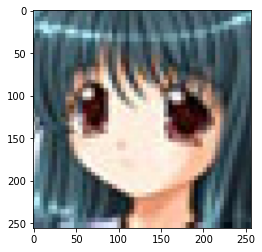

In [ ]:
plt.imshow(train_generator[100][0][5])

In [ ]:
EPOCHS = 25
Batch_Size = 32

In [ ]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [ ]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

In [ ]:
history = autoencoder.fit(
	train_generator,
	epochs=EPOCHS,
	batch_size=Batch_Size)

Epoch 1/25


InvalidArgumentError: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import argparse
import cv2

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

In [ ]:
decoded.shape

In [ ]:
testX.shape

In [ ]:
i = 500

In [ ]:
plt.imshow(testX[i], cmap=plt.cm.binary)

In [ ]:
plt.imshow(decoded[i], cmap=plt.cm.binary)